🖥️ Device: cuda

📂 Data Loading
 ✓ Subject 01: 204,082 samples in 2 files
 ✓ Subject 02: 162,206 samples in 2 files
 ✓ Subject 03: 253,233 samples in 3 files
 ✓ Subject 04: 195,737 samples in 1 files
 ✓ Subject 05: 210,632 samples in 2 files
 ✓ Subject 06: 219,934 samples in 2 files
 ✓ Subject 07: 169,860 samples in 2 files
 ✓ Subject 08: 136,589 samples in 1 files
 ✓ Subject 09: 172,311 samples in 1 files
 ✓ Subject 10: 193,303 samples in 1 files

📈 Raw Label Distribution (All):
 ADL(0): 768,092 (40.05%)
 Fall(1): 1,027,831 (53.59%)
 Pre-fall(2): 87,148 (4.54%)
 Post-fall(3): 34,816 (1.82%)

✅ Daphnet data loaded.

📊 Train/Val Split
 Train Subjects: [ 1  3  4  5  6  7  8 10]
  Val Subjects: [2 9]

🔄 Create Windows
 (Calculated mean/std)

 ✓ Windows Created: 98,854
 📊 Window Class Distribution:
  ADL     (0):  39530 (39.99%)
  Fall    (1):  54852 (55.49%)
  Pre-fall(2):   3126 ( 3.16%)
  Post-fall(3):   1346 ( 1.36%)
 (Using provided mean/std)

 ✓ Windows Created: 20,885
 📊 Window Clas

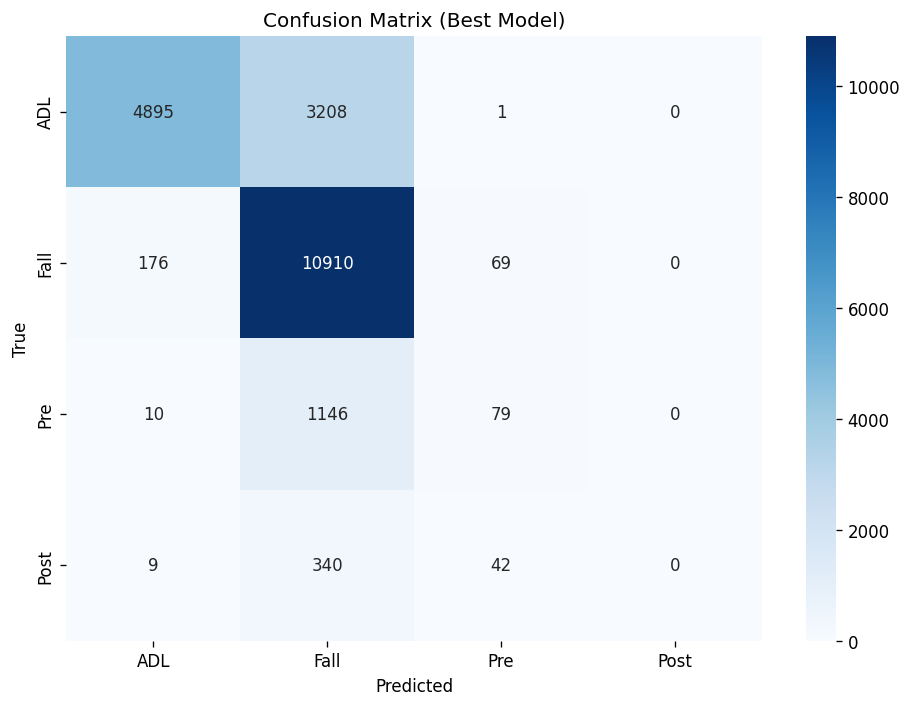

 ✓ Saved: training_history.png


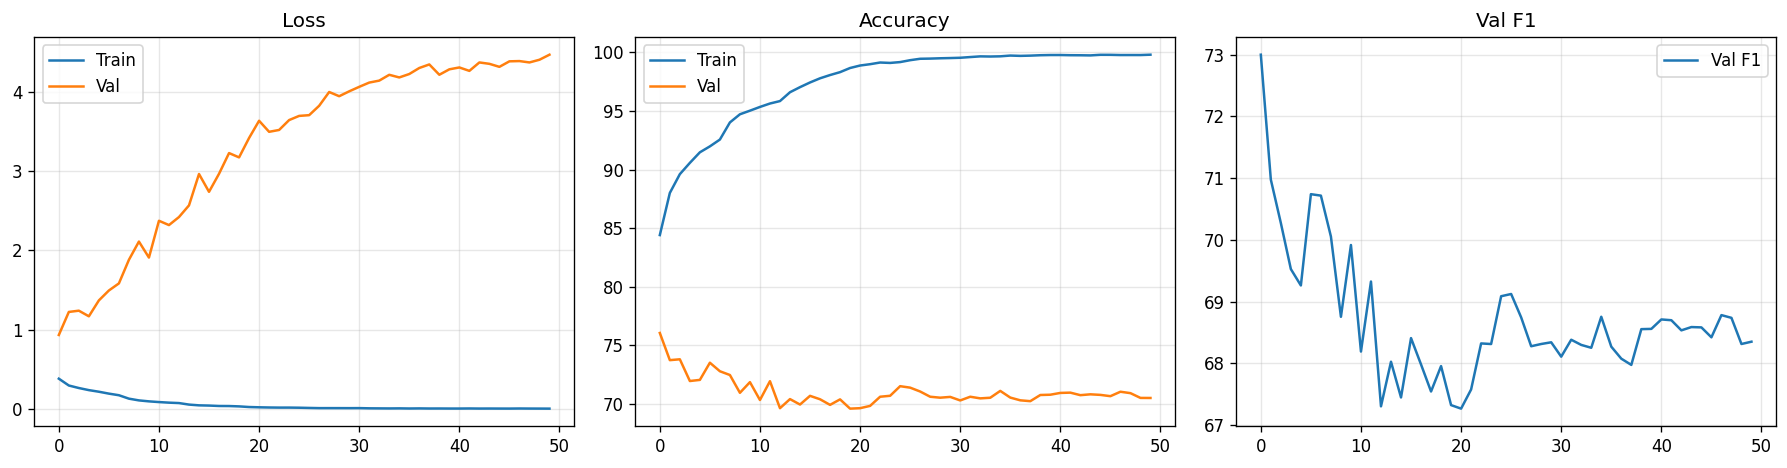

 ✓ Saved: attention_weights.png


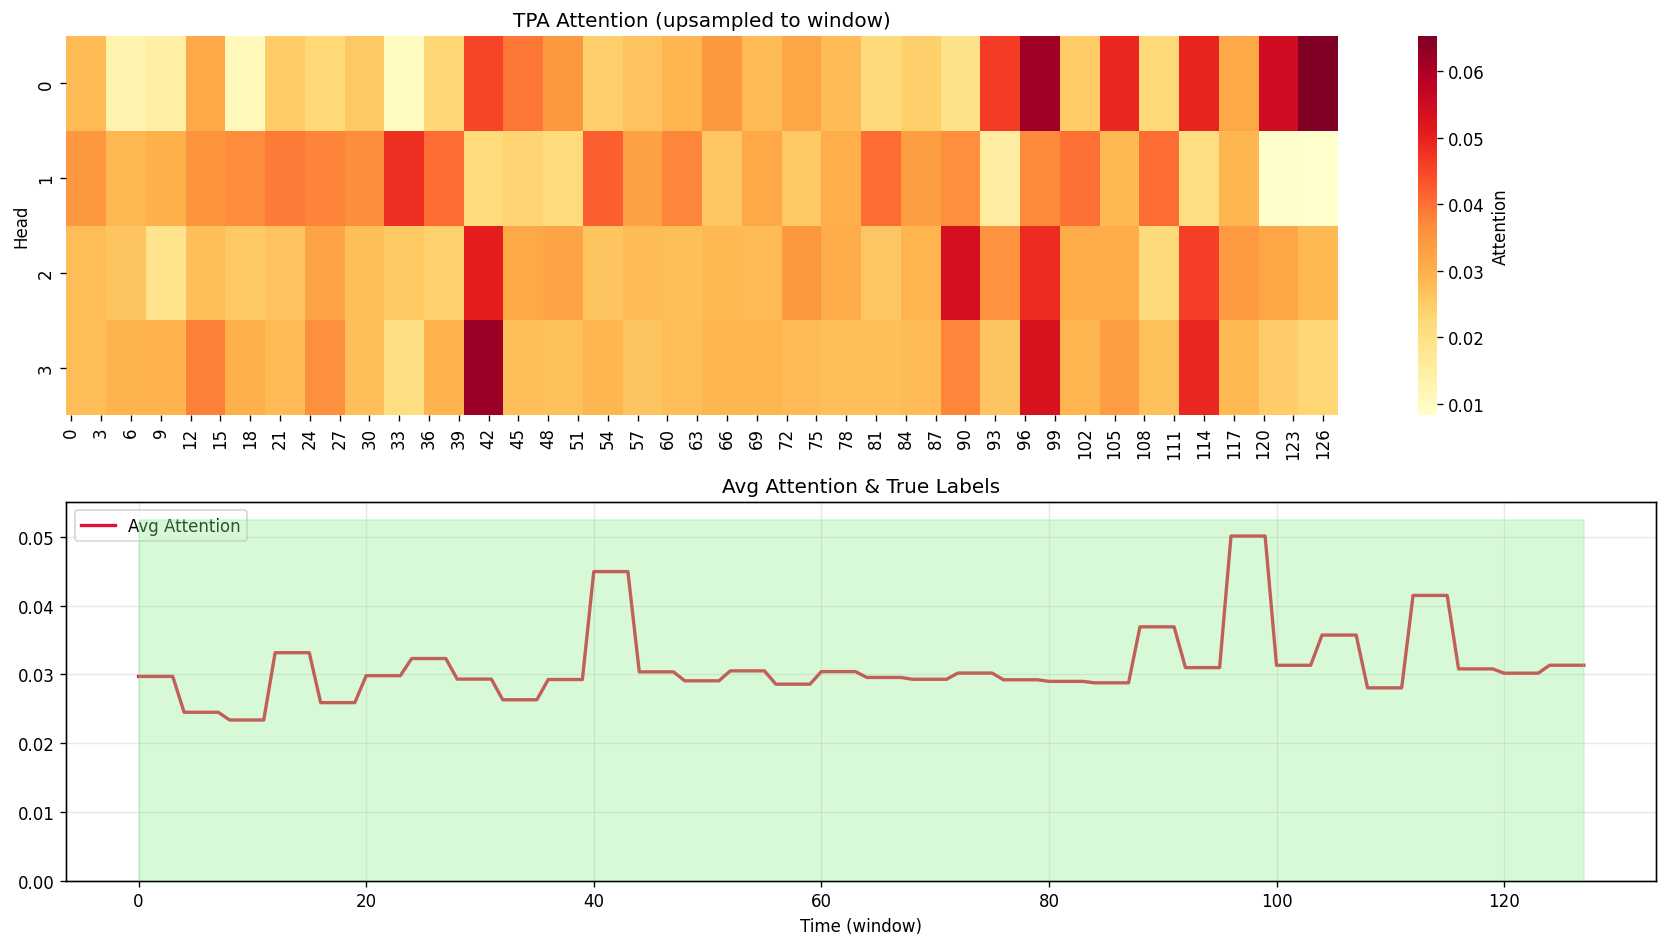


✅ Done.


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 120

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}\n")


class DaphnetLoader:
    def __init__(self, data_dir, sr=64, pre_len_sec=2.0, post_len_sec=2.0):
        self.data_dir = Path(data_dir)
        self.sr = sr
        self.pre_len = int(pre_len_sec * sr)
        self.post_len = int(post_len_sec * sr)

    def load_all(self, num_subjects=10):
        all_X, all_y, all_groups = [], [], []

        for sid in range(1, num_subjects + 1):
            files = sorted(self.data_dir.glob(f"S{sid:02d}R*.txt"))
            if not files:
                continue

            subject_samples = 0
            for f in files:
                df = pd.read_csv(f, sep=r"\s+", header=None, engine="python")
                X = df.iloc[:, :9].values.astype(np.float32)
                raw_y = df.iloc[:, -1].values.astype(int)

                y = raw_y.copy()
                for i in range(len(y) - 1):
                    if y[i] == 1 and y[i + 1] != 1:
                        end = min(i + 1 + self.post_len, len(y))
                        y[i + 1:end] = 3

                for i in range(1, len(y)):
                    if raw_y[i - 1] == 0 and raw_y[i] == 1:
                        start = max(0, i - self.pre_len)
                        y[start:i] = 2

                all_X.append(X)
                all_y.append(y)
                all_groups.append(sid)
                subject_samples += len(X)

            print(f" ✓ Subject {sid:02d}: {subject_samples:,} samples in {len(files)} files")

        if not all_X:
            raise ValueError("No Daphnet files found.")

        total = sum(len(seg) for seg in all_X)
        y_concat = np.concatenate(all_y, axis=0)
        unique, counts = np.unique(y_concat, return_counts=True)
        label_names = {0:'ADL',1:'Fall',2:'Pre-fall',3:'Post-fall'}
        print(f"\n📈 Raw Label Distribution (All):")
        for u, c in zip(unique, counts):
            print(f" {label_names.get(u,u)}({u}): {c:,} ({100*c/total:.2f}%)")

        return all_X, all_y, all_groups


class SampleDataGenerator:
    def __init__(self, sr=64):
        self.sr = sr

    def generate(self, num_falls=300):
        all_X, all_y = [], []
        for i in range(num_falls):
            n_pre, n_fall, n_post = 80, 80, 128
            n = n_pre + n_fall + n_post
            X = np.zeros((n, 9), dtype=np.float32)
            y = np.zeros(n, dtype=int)

            t = np.linspace(0, 1.25, n_pre)
            for ch in range(9):
                X[:n_pre, ch] = np.linspace(0, 4, n_pre) * np.sin(2*np.pi*4*t + ch*0.3) + np.random.randn(n_pre)*0.8
            y[:n_pre] = 2

            mag = np.random.uniform(15, 25)
            decay = np.exp(-np.linspace(0, 1.5, n_fall))
            for ch in range(9):
                X[n_pre:n_pre+n_fall, ch] = (np.random.randn(n_fall) * mag) * decay
            y[n_pre:n_pre+n_fall] = 1

            X[n_pre+n_fall:, :] = np.random.randn(n_post, 9)*0.1
            y[n_pre+n_fall:] = 3

            all_X.append(X)
            all_y.append(y)

        for i in range(num_falls):
            dur = np.random.uniform(2.0, 3.5)
            n = int(dur * self.sr)
            X = np.zeros((n, 9), dtype=np.float32)
            t = np.linspace(0, dur, n)
            for ch in range(9):
                X[:, ch] = np.sin(2*np.pi*1.5*t + ch*0.2)*(1+ch*0.15) + np.random.randn(n)*0.25
            y = np.zeros(n, dtype=int)
            all_X.append(X)
            all_y.append(y)

        total = sum(len(seg) for seg in all_X)
        y_concat = np.concatenate(all_y, axis=0)
        unique, counts = np.unique(y_concat, return_counts=True)
        label_names = {0:'ADL',1:'Fall',2:'Pre-fall',3:'Post-fall'}
        print(f"\n📈 Raw Label Distribution (Sample):")
        for u, c in zip(unique, counts):
            print(f" {label_names.get(u,u)}({u}): {c:,} ({100*c/total:.2f}%)")
        return all_X, all_y


class FallDataset(Dataset):
    def __init__(self, segments_X, segments_y, window_size=128, stride=16, mean=None, std=None):
        self.window_size = window_size
        self.stride = stride

        if mean is None or std is None:
            if len(segments_X) == 0:
                self.mean = np.zeros(9, dtype=np.float32)
                self.std = np.ones(9, dtype=np.float32)
            else:
                X_concat = np.concatenate(segments_X, axis=0)
                self.mean = X_concat.mean(axis=0).astype(np.float32)
                self.std = (X_concat.std(axis=0) + 1e-6).astype(np.float32)
            print(" (Calculated mean/std)")
        else:
            self.mean = mean.astype(np.float32)
            self.std = std.astype(np.float32)
            print(" (Using provided mean/std)")

        self.windows, self.labels, self.frame_labels = self._make_windows(segments_X, segments_y)

        names = ['ADL', 'Fall', 'Pre-fall', 'Post-fall']
        total = len(self.labels)
        print(f"\n ✓ Windows Created: {total:,}")
        if total:
            uniq, cnt = np.unique(self.labels, return_counts=True)
            d = dict(zip(uniq, cnt))
            print(" 📊 Window Class Distribution:")
            for i, n in enumerate(names):
                c = d.get(i, 0)
                print(f"  {n:8s}({i}): {c:6d} ({100*c/total:5.2f}%)")
        else:
            print(" WARNING: No windows created.")

    def _make_windows(self, X_list, y_list):
        windows, labels, frame_labels = [], [], []
        for X_seg, y_seg in zip(X_list, y_list):
            Xn = (X_seg - self.mean) / self.std
            L = len(Xn)
            for i in range(0, L - self.window_size + 1, self.stride):
                w = Xn[i:i+self.window_size]
                yl = y_seg[i:i+self.window_size]
                uniq, cnt = np.unique(yl, return_counts=True)
                ratio = dict(zip(uniq, cnt/len(yl)))
                if ratio.get(1,0) >= 0.10: lbl = 1
                elif ratio.get(3,0) >= 0.10: lbl = 3
                elif ratio.get(2,0) >= 0.10: lbl = 2
                else: lbl = 0

                windows.append(w.astype(np.float32))
                labels.append(lbl)
                frame_labels.append(yl.astype(int))

        labels = np.array(labels, dtype=int)
        return windows, labels, frame_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        w = torch.from_numpy(self.windows[idx]).float().transpose(0,1)
        y = torch.tensor(self.labels[idx]).long()
        fl = torch.from_numpy(self.frame_labels[idx]).long()
        return w, y, fl


class FormalTPA(nn.Module):
    def __init__(self, dim, heads=4, tau=1.0, bias_scale=1.0):
        super().__init__()
        assert dim % heads == 0
        self.dim = dim
        self.heads = heads
        self.dim_head = dim // heads
        self.scale = self.dim_head ** -0.5
        self.tau = tau
        self.bias_scale = bias_scale

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        self.delta_norm = nn.LayerNorm(dim)
        self.delta_act = nn.GELU()
        self.delta_net = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.GELU(),
            nn.Linear(dim // 2, heads * 2)
        )
        self.res_norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, T, D = x.shape
        H, Dh = self.heads, self.dim_head

        delta = torch.zeros_like(x)
        delta[:, 1:, :] = x[:, 1:, :] - x[:, :-1, :]
        delta = self.delta_norm(delta)

        gate_scores = self.delta_net(delta)
        logit_bias_scores, value_gate_logits = torch.chunk(gate_scores, 2, dim=-1)

        logit_bias_weights = F.softmax(logit_bias_scores.transpose(1, 2) / self.tau, dim=-1)
        logit_bias = self.bias_scale * logit_bias_weights.unsqueeze(2)

        value_gate = torch.sigmoid(value_gate_logits).permute(0, 2, 1).unsqueeze(-1)

        q = self.q_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        k = self.k_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        v = self.v_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)

        v_gated = v * value_gate

        logits = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        logits = logits + logit_bias
        attn = F.softmax(logits, dim=-1)

        out = torch.matmul(attn, v_gated)
        out = out.permute(0, 2, 1, 3).reshape(B, T, D)
        out = self.out_proj(out)
        out = self.res_norm(x + out)

        return out, logit_bias_weights


class DualStrideEncoder(nn.Module):
    def __init__(self, in_ch=9, dim=128):
        super().__init__()
        self.fine = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(dim), nn.ReLU()
        )
        self.coarse = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=7, padding=6, dilation=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(64, 128, kernel_size=5, padding=4, dilation=2),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, dim, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm1d(dim), nn.ReLU()
        )
        self.proj = nn.Sequential(
            nn.Conv1d(dim*2, dim, kernel_size=1),
            nn.BatchNorm1d(dim), nn.ReLU()
        )

    def forward(self, x):
        f = self.fine(x)
        c = self.coarse(x)

        if c.size(-1) != f.size(-1):
            c = F.interpolate(c, size=f.size(-1), mode='nearest')

        h = torch.cat([f, c], dim=1)
        h = self.proj(h)
        h = h.transpose(1, 2)
        return h


class DualStrideTPA_FallModel(nn.Module):
    def __init__(self, in_ch=9, dim=128, num_classes=4, heads=4, tau=1.0, bias_scale=1.0):
        super().__init__()
        self.encoder = DualStrideEncoder(in_ch=in_ch, dim=dim)
        self.tpa = FormalTPA(dim=dim, heads=heads, tau=tau, bias_scale=bias_scale)
        self.classifier = nn.Sequential(
            nn.Linear(dim, dim//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(dim//2, num_classes)
        )

    def forward(self, x, return_attention=False):
        h = self.encoder(x)
        h, attn_w = self.tpa(h)
        pooled = h.mean(dim=1)
        logits = self.classifier(pooled)

        if return_attention:
            return logits, attn_w
        return logits


class Trainer:
    def __init__(self, model, device, class_weights=None, lr=1e-3):
        self.model = model.to(device)
        if class_weights is not None:
            class_weights = torch.FloatTensor(class_weights).to(device)
            print(f"\n ✓ Using Class Weights: {class_weights.detach().cpu().numpy()}")
        else:
            print("\n ✓ Using No Class Weights")
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.5, patience=5)

        self.history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'val_f1':[]}

    def train_epoch(self, loader):
        self.model.train()
        loss_sum, correct, total = 0.0, 0, 0
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            logits = self.model(x)
            loss = self.criterion(logits, y)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            loss_sum += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        return loss_sum/len(loader), 100.0*correct/total

    @torch.no_grad()
    def validate(self, loader):
        self.model.eval()
        loss_sum, preds, gts = 0.0, [], []
        if len(loader) == 0:
            return 0.0, 0.0, 0.0, [], []
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            logits = self.model(x)
            loss = self.criterion(logits, y)
            loss_sum += loss.item()
            preds.extend(logits.argmax(dim=1).cpu().numpy().tolist())
            gts.extend(y.cpu().numpy().tolist())
        acc = 100.0 * (np.array(preds) == np.array(gts)).mean()
        f1 = 100.0 * f1_score(gts, preds, average='weighted', zero_division=0)
        return loss_sum/len(loader), acc, f1, preds, gts

    def fit(self, train_loader, val_loader, epochs=25):
        best_f1 = 0.0
        print("\n" + "="*90)
        print("🚀 Training (Dual-Stride + Formal TPA)")
        print("="*90)
        for ep in range(1, epochs+1):
            tr_loss, tr_acc = self.train_epoch(train_loader)
            va_loss, va_acc, va_f1, preds, gts = self.validate(val_loader)
            self.scheduler.step(va_f1)

            self.history['train_loss'].append(tr_loss)
            self.history['train_acc'].append(tr_acc)
            self.history['val_loss'].append(va_loss)
            self.history['val_acc'].append(va_acc)
            self.history['val_f1'].append(va_f1)

            msg = f"[{ep:02d}/{epochs}] Loss {tr_loss:.4f}/{va_loss:.4f} | Acc {tr_acc:5.2f}/{va_acc:5.2f}% | F1 {va_f1:5.2f}%"
            if va_f1 > best_f1:
                best_f1 = va_f1
                torch.save(self.model.state_dict(), "best_model.pth")
                msg += "  ✓ Best"
            print(msg)
        print(f"\n✅ Best Val F1: {best_f1:.2f}%")
        return preds, gts


class Visualizer:
    @staticmethod
    def plot_confusion(y_true, y_pred, save_path=None):
        cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['ADL','Fall','Pre','Post'],
                    yticklabels=['ADL','Fall','Pre','Post'])
        plt.title('Confusion Matrix (Best Model)')
        plt.xlabel('Predicted'); plt.ylabel('True')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f" ✓ Saved: {save_path}")
        plt.show()

    @staticmethod
    def plot_history(hist, save_path=None):
        fig, axes = plt.subplots(1,3, figsize=(15,4))
        axes[0].plot(hist['train_loss'], label='Train'); axes[0].plot(hist['val_loss'], label='Val')
        axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(alpha=.3)

        axes[1].plot(hist['train_acc'], label='Train'); axes[1].plot(hist['val_acc'], label='Val')
        axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(alpha=.3)

        axes[2].plot(hist['val_f1'], label='Val F1'); axes[2].set_title('Val F1'); axes[2].legend(); axes[2].grid(alpha=.3)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f" ✓ Saved: {save_path}")
        plt.show()

    @staticmethod
    def plot_attention(model, batch_x, batch_frame_labels, device, save_path=None):
        model.eval()
        with torch.no_grad():
            logits, attn = model(batch_x.to(device), return_attention=True)
        attn = attn[0].cpu().numpy()
        labels = batch_frame_labels[0].numpy()

        H, T_enc = attn.shape
        T_win = len(labels)
        attn_t = torch.from_numpy(attn).unsqueeze(0)
        attn_up = F.interpolate(attn_t, size=T_win, mode='nearest').squeeze(0).numpy()

        fig, axes = plt.subplots(2,1, figsize=(14,8), gridspec_kw={'height_ratios':[1,1]})
        sns.heatmap(attn_up, ax=axes[0], cmap='YlOrRd', cbar_kws={'label':'Attention'})
        axes[0].set_ylabel('Head'); axes[0].set_title('TPA Attention (upsampled to window)')
        avg_attn = attn_up.mean(axis=0)
        axes[1].plot(avg_attn, lw=2, label='Avg Attention', color='crimson')
        axes[1].set_ylim(0, avg_attn.max()*1.1)
        axes[1].grid(alpha=.3); axes[1].legend(loc='upper left')
        ax2 = axes[1].twinx()
        name2col = {0:'lightgreen',1:'red',2:'orange',3:'lightblue'}
        for k, col in name2col.items():
            mask = labels == k
            if mask.any():
                ax2.fill_between(np.arange(T_win), 0, 1, where=mask, color=col, alpha=.35, step='post', label=f"{k}")
        ax2.set_yticks([]); ax2.set_ylim(0,1.05)
        axes[1].set_xlabel('Time (window)')
        axes[1].set_title('Avg Attention & True Labels')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f" ✓ Saved: {save_path}")
        plt.show()


def main():
    CONFIG = {
        'window_size': 128,
        'stride': 16,
        'batch_size': 256,
        'epochs': 50,
        'hidden_dim': 128,
        'daphnet_path': '/content/drive/MyDrive/HAR_Dataset/DAPHNET/dataset',
        'use_daphnet': True,
        'tpa_heads': 4,
        'tpa_tau': 1.0,
        'tpa_bias_scale': 1.0,
        'class_weights': [1.0, 5.0, 8.0, 8.0],
        'subjects': 10,
        'sr': 64,
        'pre_sec': 2.0,
        'post_sec': 2.0,
    }

    print("="*90)
    print("📂 Data Loading")
    print("="*90)
    groups = None
    try:
        if CONFIG['use_daphnet']:
            loader = DaphnetLoader(CONFIG['daphnet_path'], sr=CONFIG['sr'],
                                   pre_len_sec=CONFIG['pre_sec'], post_len_sec=CONFIG['post_sec'])
            X_segs, y_segs, groups = loader.load_all(CONFIG['subjects'])
            print("\n✅ Daphnet data loaded.")
        else:
            raise RuntimeError("Force sample data")
    except Exception as e:
        print(f"⚠️ Daphnet not available: {e}\nUsing synthetic sample data...")
        gen = SampleDataGenerator(sr=CONFIG['sr'])
        X_segs, y_segs = gen.generate(num_falls=300)
        groups = None

    print("\n" + "="*90)
    print("📊 Train/Val Split")
    print("="*90)
    if groups is not None:=
        groups = np.array(groups)
        idx = np.arange(len(X_segs))
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        train_idx, val_idx = next(gss.split(idx, groups=groups))
        X_train = [X_segs[i] for i in train_idx]
        y_train = [y_segs[i] for i in train_idx]
        X_val   = [X_segs[i] for i in val_idx]
        y_val   = [y_segs[i] for i in val_idx]
        print(f" Train Subjects: {np.unique(groups[train_idx])}")
        print(f"  Val Subjects: {np.unique(groups[val_idx])}")
    else:
        X_train, X_val, y_train, y_val = train_test_split(X_segs, y_segs, test_size=0.2, random_state=SEED)
        print(f" Train segments: {len(X_train)} | Val segments: {len(X_val)}")

    print("\n" + "="*90)
    print("🔄 Create Windows")
    print("="*90)
    train_ds = FallDataset(X_train, y_train, window_size=CONFIG['window_size'], stride=CONFIG['stride'])
    val_ds   = FallDataset(X_val,   y_val,   window_size=CONFIG['window_size'], stride=CONFIG['stride'],
                           mean=train_ds.mean, std=train_ds.std)

    train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=CONFIG['batch_size'], shuffle=False, drop_last=False)

    print("\n" + "="*90)
    print("🏗️ Build Model (Dual-Stride + Formal TPA)")
    print("="*90)
    model = DualStrideTPA_FallModel(
        in_ch=9,
        dim=CONFIG['hidden_dim'],
        num_classes=4,
        heads=CONFIG['tpa_heads'],
        tau=CONFIG['tpa_tau'],
        bias_scale=CONFIG['tpa_bias_scale']
    )
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f" ✓ Parameters: {n_params:,}")
    print(f" ✓ TPA: heads={CONFIG['tpa_heads']}, tau={CONFIG['tpa_tau']}, bias_scale={CONFIG['tpa_bias_scale']}")

    weights = CONFIG['class_weights']
    print("\n⚖️ Class Weights:")
    for name, w in zip(['ADL','Fall','Pre','Post'], weights):
        print(f" {name:7s}: {w:.2f}")

    trainer = Trainer(model, device, class_weights=weights, lr=1e-3)

    preds, gts = trainer.fit(train_loader, val_loader, epochs=CONFIG['epochs'])

    print("\n" + "="*90)
    print("🏆 Final Evaluation (Best Checkpoint)")
    print("="*90)
    try:
        model.load_state_dict(torch.load("best_model.pth", map_location=device))
        print(" ✓ Loaded best_model.pth")
    except FileNotFoundError:
        print(" ⚠️ best_model.pth not found. Using the last epoch model.")

    _, val_acc, val_f1, preds, gts = trainer.validate(val_loader)
    print(f"\n Best Model Validation: Acc {val_acc:.2f}% | F1 {val_f1:.2f}%\n")

    if len(gts):
        print(classification_report(gts, preds, labels=[0,1,2,3],
                                    target_names=['ADL','Fall','Pre-fall','Post-fall'],
                                    digits=4, zero_division=0))

    vis = Visualizer()
    if len(gts):
        vis.plot_confusion(gts, preds, save_path="confusion_matrix.png")
    vis.plot_history(trainer.history, save_path="training_history.png")

    try:
        batch_x, _, batch_fl = next(iter(val_loader))
        vis.plot_attention(model, batch_x[:1], batch_fl[:1], device, save_path="attention_weights.png")
    except StopIteration:
        print(" ⚠️ Validation loader is empty; skip attention plot.")

    print("\n✅ Done.")


if __name__ == "__main__":
    main()